In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from utils.paths import BOOKS_PATH

# ======= 1. Wczytanie danych =======  # Zmień na swoją ścieżkę pliku
df_books = pd.read_csv(BOOKS_PATH)  # Ograniczenie do 5000 rekordów dla oszczędności pamięci

# ======= 2. Tworzenie etykiety bestsellerów (top 20%) =======
threshold = 2000
df_books["bestseller"] = (df_books["number_of_people_has"] >= threshold).astype(int)

# ======= 3. Feature Engineering (tylko dostępne przed premierą) =======
df_books["description_length"] = df_books["description"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# Oceny (możemy zebrać przed premierą)
rating_features = [f"rating_{i}" for i in range(1, 11)]

# Ograniczenie liczby autorów do 100 najpopularniejszych
top_authors = df_books["author"].value_counts().index[:100]
df_books["is_top_author"] = df_books["author"].apply(lambda x: 1 if x in top_authors else 0)

# Kategoryczne cechy
categorical_features = ["Kategoria", "Format", "Cykl"]

# Label Encoding dla kategorii
le = LabelEncoder()
for col in categorical_features:
    df_books[col] = df_books[col].fillna("Unknown")
    df_books[col] = le.fit_transform(df_books[col])

# ======= 4. Wybór finalnych cech =======
selected_features = ["description_length", "is_top_author"] + rating_features + categorical_features

# Usunięcie brakujących wartości
df_class_final = df_books[selected_features + ["bestseller"]].dropna()

# ======= 5. Podział na zbiór treningowy i testowy =======
X = df_class_final[selected_features]
y = df_class_final["bestseller"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizacja ocen (standaryzacja)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======= 6. Trenowanie modeli =======
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42)
}

results = []
classification_reports = {}

for name, model in models.items():
    print(f"Trenowanie modelu: {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": accuracy})
    
    # Raport klasyfikacji
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports[name] = pd.DataFrame(report).transpose()
    
    # Zapis raportu do pliku CSV
    classification_reports[name].to_csv(f"classification_report_{name.replace(' ', '_')}.csv")
    print(f"Zapisano raport dla {name} do pliku classification_report_{name.replace(' ', '_')}.csv")

# ======= 7. Zapis wyników klasyfikacji =======
results_df = pd.DataFrame(results)
results_df.to_csv("bestseller_classification_results.csv", index=False)
print("Wyniki zapisano do pliku bestseller_classification_results.csv")

print("\n✅ Klasyfikacja bestsellerów zakończona! Sprawdź pliki CSV z wynikami.")


/tmp/ipykernel_158101/110385215.py:12: DtypeWarning: Columns (66,67,68,69,70,71,72,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv(BOOKS_PATH)  # Ograniczenie do 5000 rekordów dla oszczędności pamięci


Trenowanie modelu: Logistic Regression...
Zapisano raport dla Logistic Regression do pliku classification_report_Logistic_Regression.csv
Trenowanie modelu: Random Forest...
Zapisano raport dla Random Forest do pliku classification_report_Random_Forest.csv
Wyniki zapisano do pliku bestseller_classification_results.csv

✅ Klasyfikacja bestsellerów zakończona! Sprawdź pliki CSV z wynikami.


/tmp/ipykernel_157454/891534369.py:9: DtypeWarning: Columns (66,67,68,69,70,71,72,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv(BOOKS_PATH)  # Ograniczenie do 5000 rekordów dla oszczędności pamięci


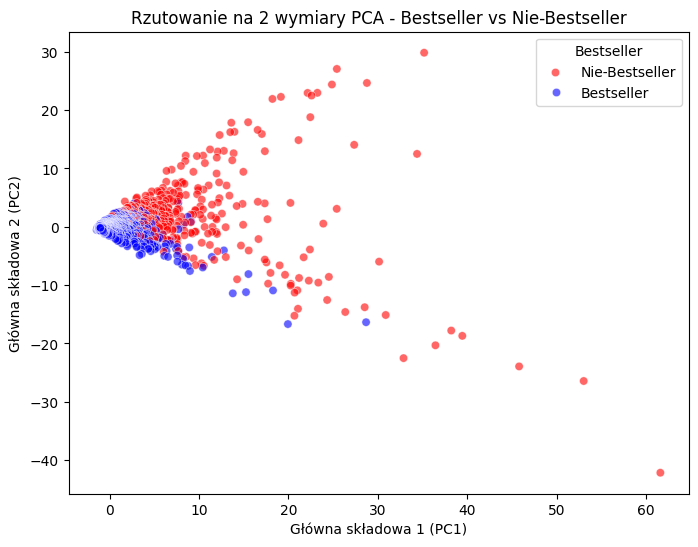

PC1 wyjaśnia 44.55% wariancji
PC2 wyjaśnia 16.95% wariancji


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ======= 1. Wczytanie danych =======
df_books = pd.read_csv(BOOKS_PATH)  # Ograniczenie do 5000 rekordów dla oszczędności pamięci

# ======= 2. Tworzenie etykiety bestsellerów (≥ 2000 posiadaczy) =======
bestseller_threshold = 2000
df_books["bestseller"] = (df_books["number_of_people_has"] >= bestseller_threshold).astype(int)

# ======= 3. Feature Engineering (tylko dostępne przed premierą) =======
df_books["description_length"] = df_books["description"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# Oceny (możemy zebrać przed premierą)
rating_features = [f"rating_{i}" for i in range(1, 11)]

# Ograniczenie liczby autorów do 100 najpopularniejszych
top_authors = df_books["author"].value_counts().index[:100]
df_books["is_top_author"] = df_books["author"].apply(lambda x: 1 if x in top_authors else 0)

# Kategoryczne cechy
categorical_features = ["Kategoria", "Format", "Cykl"]

# Label Encoding dla kategorii
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_features:
    df_books[col] = df_books[col].fillna("Unknown")
    df_books[col] = le.fit_transform(df_books[col])

# ======= 4. Wybór finalnych cech =======
selected_features = ["description_length", "is_top_author"] + rating_features + categorical_features

# Usunięcie brakujących wartości
df_class_final = df_books[selected_features + ["bestseller"]].dropna()

# ======= 5. PCA - Redukcja wymiarów do 2D =======
X_pca = df_class_final[selected_features]
y_pca = df_class_final["bestseller"]

# Normalizacja danych przed PCA
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

# Wykonanie PCA na 2 wymiary
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_pca_scaled)

# Tworzenie DataFrame z wynikami PCA
df_pca = pd.DataFrame(X_pca_2d, columns=["PC1", "PC2"])
df_pca["bestseller"] = y_pca.values

# ======= 6. Wizualizacja PCA =======
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="bestseller", alpha=0.6, palette={0: "blue", 1: "red"})
plt.xlabel("Główna składowa 1 (PC1)")
plt.ylabel("Główna składowa 2 (PC2)")
plt.title("Rzutowanie na 2 wymiary PCA - Bestseller vs Nie-Bestseller")
plt.legend(title="Bestseller", labels=["Nie-Bestseller", "Bestseller"])
plt.show()

# ======= 7. Sprawdzenie wyjaśnionej wariancji przez PCA =======
explained_variance = pca.explained_variance_ratio_
print(f"PC1 wyjaśnia {explained_variance[0] * 100:.2f}% wariancji")
print(f"PC2 wyjaśnia {explained_variance[1] * 100:.2f}% wariancji")


/home/mateusz/dev/lubimyczytac_project/lubimyczytac/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_157454/424919352.py:9: DtypeWarning: Columns (66,67,68,69,70,71,72,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv(BOOKS_PATH)  # Ograniczenie do 5000 rekordów
/home/mateusz/dev/lubimyczytac_project/lubimyczytac/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mateusz/dev/lubimyczytac_project/lubimyczytac/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


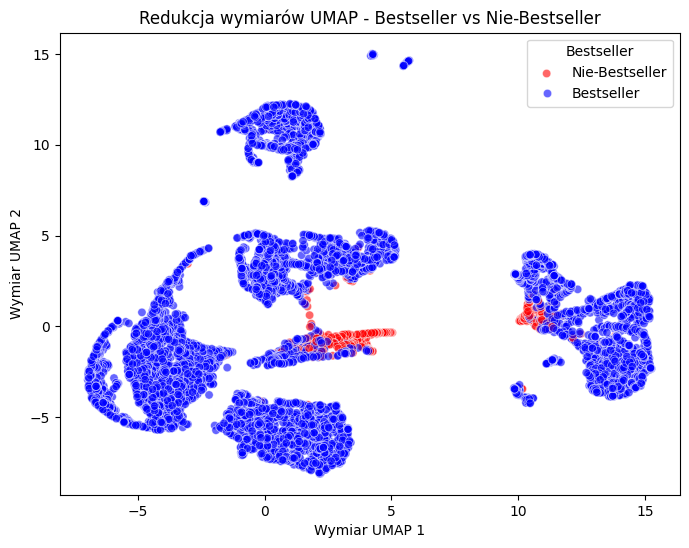

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

# ======= 1. Wczytanie danych =======
df_books = pd.read_csv(BOOKS_PATH)  # Ograniczenie do 5000 rekordów

# ======= 2. Tworzenie etykiety bestsellerów (≥ 2000 posiadaczy) =======
bestseller_threshold = 2000
df_books["bestseller"] = (df_books["number_of_people_has"] >= bestseller_threshold).astype(int)

# ======= 3. Feature Engineering =======
df_books["description_length"] = df_books["description"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

rating_features = [f"rating_{i}" for i in range(1, 11)]
top_authors = df_books["author"].value_counts().index[:100]
df_books["is_top_author"] = df_books["author"].apply(lambda x: 1 if x in top_authors else 0)

categorical_features = ["Kategoria", "Format", "Cykl"]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_features:
    df_books[col] = df_books[col].fillna("Unknown")
    df_books[col] = le.fit_transform(df_books[col])

# ======= 4. Wybór finalnych cech =======
selected_features = ["description_length", "is_top_author"] + rating_features + categorical_features
df_class_final = df_books[selected_features + ["bestseller"]].dropna()

# ======= 5. UMAP - Redukcja wymiarów do 2D =======
X_umap = df_class_final[selected_features]
y_umap = df_class_final["bestseller"]

scaler_umap = StandardScaler()
X_umap_scaled = scaler_umap.fit_transform(X_umap)

# Wykonanie UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap_2d = reducer.fit_transform(X_umap_scaled)

# Tworzenie DataFrame z wynikami UMAP
df_umap = pd.DataFrame(X_umap_2d, columns=["UMAP1", "UMAP2"])
df_umap["bestseller"] = y_umap.values

# ======= 6. Wizualizacja UMAP =======
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="bestseller", alpha=0.6, palette={0: "blue", 1: "red"})
plt.xlabel("Wymiar UMAP 1")
plt.ylabel("Wymiar UMAP 2")
plt.title("Redukcja wymiarów UMAP - Bestseller vs Nie-Bestseller")
plt.legend(title="Bestseller", labels=["Nie-Bestseller", "Bestseller"])
plt.show()


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

# ======= 1. Wczytanie danych =======
df_books = pd.read_csv(BOOKS_PATH)  # Zmień ścieżkę na swoją

# ======= 2. Tworzenie etykiety bestsellerów (≥ 2000 posiadaczy) =======
bestseller_threshold = 2000
df_books["bestseller"] = (df_books["number_of_people_has"] >= bestseller_threshold).astype(int)

# ======= 3. Feature Engineering =======
df_books["description_length"] = df_books["description"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

rating_features = [f"rating_{i}" for i in range(1, 11)]
top_authors = df_books["author"].value_counts().index[:100]
df_books["is_top_author"] = df_books["author"].apply(lambda x: 1 if x in top_authors else 0)

categorical_features = ["Kategoria", "Format", "Cykl"]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_features:
    df_books[col] = df_books[col].fillna("Unknown")
    df_books[col] = le.fit_transform(df_books[col])

# ======= 4. Wybór finalnych cech =======
selected_features = ["description_length", "is_top_author"] + rating_features + categorical_features
df_class_final = df_books[selected_features + ["bestseller"]].dropna()

# ======= 5. UMAP - Redukcja wymiarów do 3D =======
X_umap = df_class_final[selected_features]
y_umap = df_class_final["bestseller"]

scaler_umap = StandardScaler()
X_umap_scaled = scaler_umap.fit_transform(X_umap)

# Wykonanie UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
X_umap_3d = reducer.fit_transform(X_umap_scaled)

# Tworzenie DataFrame z wynikami UMAP
df_umap = pd.DataFrame(X_umap_3d, columns=["UMAP1", "UMAP2", "UMAP3"])
df_umap["bestseller"] = y_umap.values

# ======= 6. Wizualizacja interaktywna 3D w Plotly =======
fig = px.scatter_3d(df_umap, x="UMAP1", y="UMAP2", z="UMAP3", 
                     color=df_umap["bestseller"].astype(str),
                     title="UMAP 3D - Bestseller vs Nie-Bestseller",
                     labels={"color": "Bestseller"},
                     opacity=0.7)

fig.show()


/home/mateusz/dev/lubimyczytac_project/lubimyczytac/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_158101/2201087454.py:8: DtypeWarning: Columns (66,67,68,69,70,71,72,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv(BOOKS_PATH)  # Zmień ścieżkę na swoją
/home/mateusz/dev/lubimyczytac_project/lubimyczytac/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mateusz/dev/lubimyczytac_project/lubimyczytac/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
